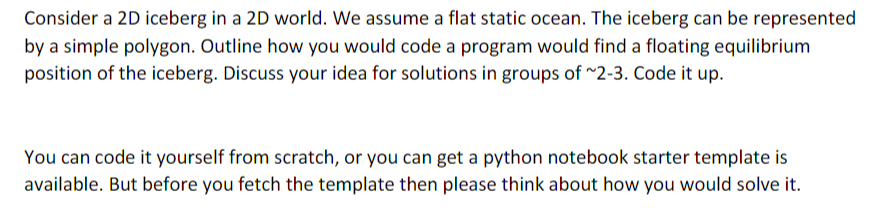

In [169]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull


In [184]:
# Assuming constant density of ice and water

def find_below_waterline(polygon, waterline):
    # loop through all the points in the polygon
    calc_polygon = []
    for i in range(len(polygon)):
        point = polygon[i%len(polygon)]
        next_point = polygon[(i+1) % len(polygon)]

        # add if the point is below the waterline
        if (point[1] < waterline):
            calc_polygon.append(point)

        # add intermediate point on waterline
        if (point[1] > waterline and next_point[1] < waterline) or (point[1] < waterline and next_point[1] > waterline):
            x = point[0] + (next_point[0] - point[0]) * (waterline - point[1]) / (next_point[1] - point[1])
            y = waterline
            calc_polygon.append((x, y))
    return np.array(calc_polygon)


# function that finds the centroid of a polygon
def centroid(polygon):
    # calculate the centroid
    x,y = 0,0
    for point in polygon:
        x += point[0]
        y += point[1]
    
    return np.array([x/len(polygon), y/len(polygon)])

def PolyArea(polygon):

    if len(polygon) <= 0:
        return 0

    return ConvexHull(polygon).volume
    
    # x, y = polygon[:,0], polygon[:,1]

    # return 0.5*np.abs(np.dot(x,np.roll(y,1)) - np.dot(y,np.roll(x,1)))

def I_over_V(polygon, waterline):

    below_waterline = find_below_waterline(polygon, waterline)
    waterline_points = [p for p in below_waterline if p[1] == waterline]

    x1 = np.min([p[0] for p in waterline_points])
    x2 = np.max([p[0] for p in waterline_points])

    mid = (x1 + x2)/2
    n = 0.01

    area = PolyArea(below_waterline)

    lens = 0
    for i in range(len(below_waterline)-1):
        point = below_waterline[i]
        next_point = below_waterline[(i+1)]

        lens += np.sqrt((point[0] - next_point[0])**2 + (point[1] - next_point[1])**2)


    # inte = np.sum([x**2 for x in np.arange(x1 - mid, x2 - mid, n)])/(area)*n

    return lens

def metacenter(iceberg, waterline):

    below_waterline = find_below_waterline(iceberg, waterline)

    return centroid(below_waterline)[1] + I_over_V(iceberg, waterline)


def is_stable(iceberg, waterline):
    # print(metacenter(iceberg, waterline), centroid(iceberg)[1])
    return centroid(iceberg)[1] < metacenter(iceberg, waterline)


iceberg = np.array([[0, 0], [0, 100], [100, 100], [100, 0]])

for i in range(1, 100, 10):
    waterline = i
    print(waterline, is_stable(iceberg, waterline))



1 True
11 True
21 True
31 True
41 True
51 True
61 True
71 True
81 True
91 True


In [181]:
PolyArea(np.array([[0, 0], [0, 2], [2, 2], [1, 2], [2, 0]]))

4.0

In [205]:
# Attempt 2

import copy
# Archimedes
# Moment-version

rho_ice = 800
rho_water = 1000

waterline = 100

g = 100

iceberg = np.array([[0, 0], [0, 200], [100, 200], [100, 0]], dtype=np.float64)


def calc_force(iceberg):
    below_water = find_below_waterline(iceberg, waterline)

    
    # Calculate the weight of the water displaced
    W_w = PolyArea(below_water) * rho_water


    centroid_w = centroid(below_water)
    centroid_i = centroid(iceberg)


    l =  np.sqrt(np.sum((centroid_i - centroid_w))**2)
    if l != 0:
        dir = (centroid_i - centroid_w)/l
    else:
        dir = np.array([0, 1]) 

    F = dir*W_w*g

    return F



v = np.array([0.0, 0.0])
a = np.array([0.0, 0.0])


dt = 1


icebergs = []
icebergs.append(iceberg)

for i in range(200):
    # plt.figure()
    # plt.plot(iceberg[:,0], iceberg[:,1])
    # plt.hlines(waterline, 0, 100)
    # plt.show()

    F_w = calc_force(iceberg)


    M_ice = PolyArea(iceberg) * rho_ice

    F_g = np.array([0, -M_ice * g])

    # print(F_w[1], F_g[1])

    a = (F_w + F_g)/(M_ice)
    a *= 0.9
    # print("a", a)
    v += a*dt

    iceberg += v*dt

    icebergs.append(copy.deepcopy(iceberg))

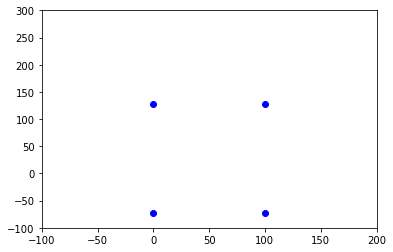

In [212]:
# matplotlib animation
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()

ax.set_xlim((-100, 200))
ax.set_ylim((-100, 300))

line, = ax.plot([], [], lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return (line, time_text)


def animate(i):
    # line.set_data(icebergs[i][:,0], icebergs[i][:,1])

    plt.clf()

    plt.scatter(icebergs[i][:, 0], icebergs[i][:, 1], c = 'b')
    time_text.set_text('time = %.1f' % i)
    plt.xlim((-100, 200))
    plt.ylim((-100, 300))
    return (line, time_text)


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

HTML(anim.to_html5_video())
